In [21]:
import pandas as pd
import numpy as np

### 시각화 라이브러리 정의
# - 파이썬에서 사용되는 기본 시각화 라이브러리
import matplotlib.pyplot as plt

# - 히트맵 라이브러리
import seaborn as sns
import geopandas as gpd
import folium
from shapely.geometry import Polygon
from shapely.geometry import Point
from folium.plugins import MarkerCluster

import os
from dask.diagnostics import ProgressBar
import dask.dataframe as dd


from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from scipy.stats import spearmanr

### 한글처리
plt.rc("font", family="Malgun Gothic")

# - 마이너스 기호 깨짐 처리
plt.rcParams["axes.unicode_minus"] = False

### 파일 불러들이고 결측치 처리

In [2]:

# 데이터 불러오기
merged_wildfire_df = pd.read_csv("./USA data/merged_wildfire_weather.csv", dtype={'version': str})

# 데이터 일부 확인
print("데이터 일부 확인:\n", merged_wildfire_df.head())

# datetime 변환
merged_wildfire_df['datetime'] = pd.to_datetime(merged_wildfire_df['datetime'])

# 결측치 확인
print("결측치 개수 (처리 전):\n", merged_wildfire_df.isnull().sum())

# 결측치 처리 (결측치가 없더라도 명시적으로 처리)
# 현재는 결측치가 없으므로 이 단계는 스킵되지만, 코드에 포함시켜 안정성 확보
merged_wildfire_df = merged_wildfire_df.dropna()

# 불필요한 컬럼 삭제
columns_to_drop = ['scan', 'track', 'satellite', 'instrument', 'version', 'type']
merged_wildfire_df = merged_wildfire_df.drop(columns=columns_to_drop)

# 데이터 타입 & 구조 확인
print("데이터 타입:\n", merged_wildfire_df.dtypes)

# 결측치 확인 (처리 후)
print("결측치 개수 (처리 후):\n", merged_wildfire_df.isnull().sum())

데이터 일부 확인:
    latitude  longitude  brightness  scan  track satellite instrument  \
0  41.18757 -121.76961      303.88  0.44   0.38         N      VIIRS   
1  41.18763 -121.76556      297.14  0.44   0.38         N      VIIRS   
2  35.51954 -119.72784      302.88  0.39   0.36         N      VIIRS   
3  37.82349 -120.96186      299.62  0.39   0.37         N      VIIRS   
4  38.91062 -121.17077      303.10  0.40   0.37         N      VIIRS   

  confidence version  bright_t31   frp daynight  type       T2M      WS2M  \
0          n       2      266.14  1.17        N   0.0 -3.275956  0.659219   
1          n       2      265.25  1.74        N   0.0 -3.262186  0.663444   
2          n       2      270.62  1.20        N   0.0  4.008612  1.561859   
3          n       2      271.62  0.82        N   0.0  2.606993  1.395697   
4          n       2      272.36  1.11        N   0.0  1.478034  1.415668   

        RH2M  PRECTOTCORR             datetime  
0  68.094241     0.000161  2015-01-01 09:56

### 이상치 처리하기

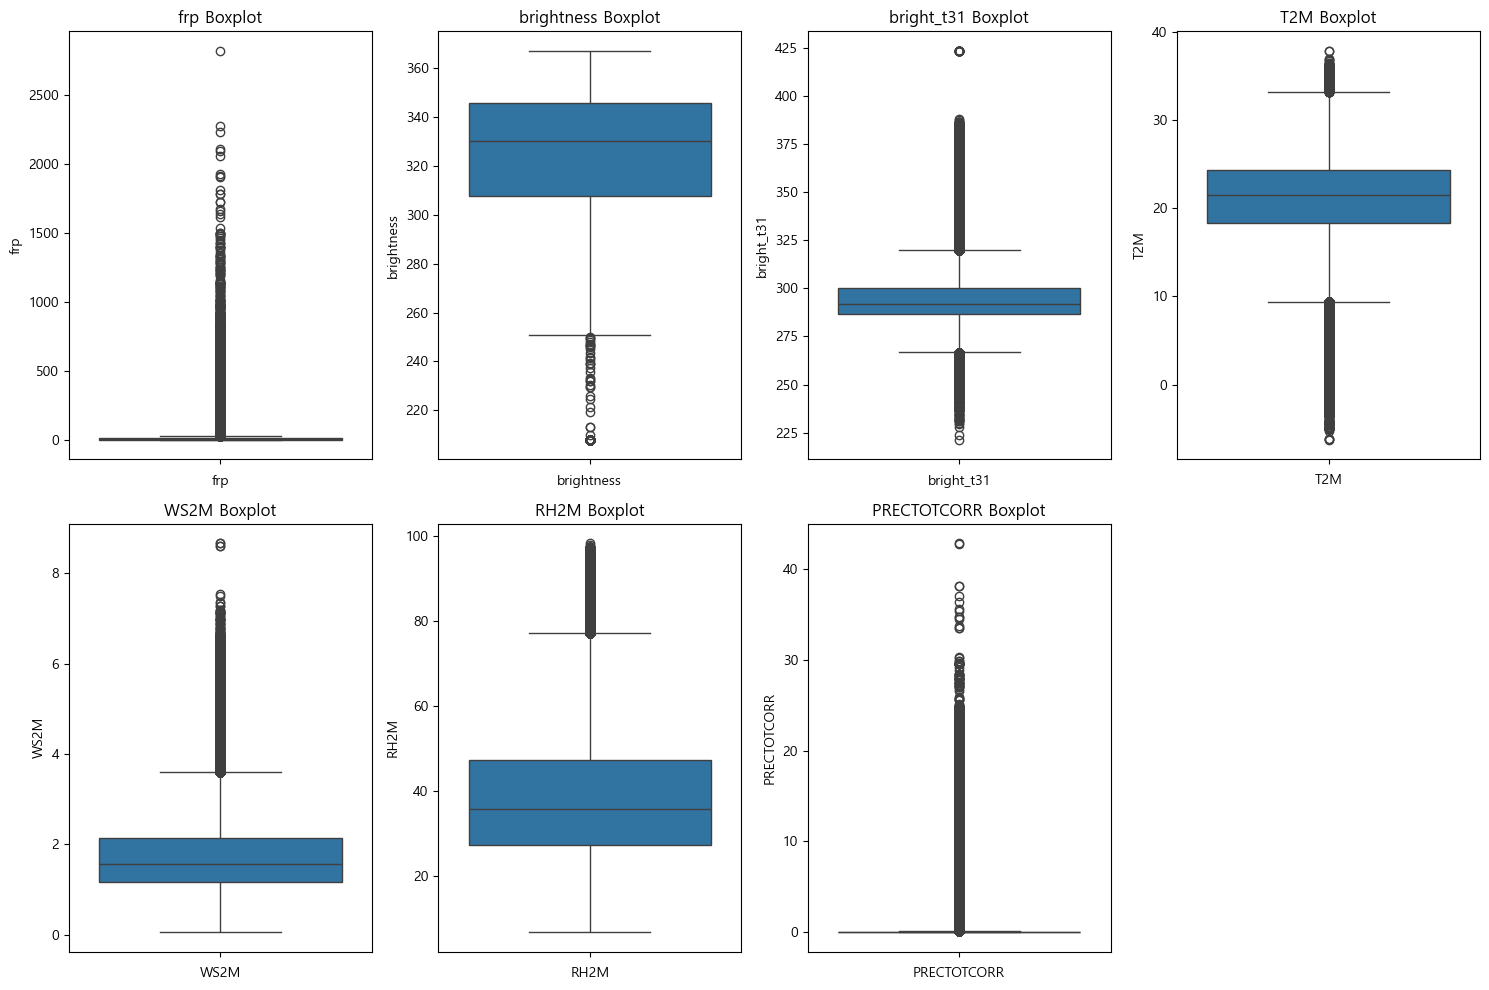

In [ ]:
# 여러 변수에 대해 boxplot을 한 번에 그리기
plt.figure(figsize=(15, 10))

# 각 변수에 대해 Boxplot 생성
variables = ["frp", "brightness", "bright_t31", "T2M", "WS2M", "RH2M", "PRECTOTCORR"]
for i, v in enumerate(variables, 1):
    plt.subplot(2, 4, i) # 2행 4열
    sns.boxplot(merged_wildfire_df[v])
    plt.title(f"{v} Boxplot")
    plt.xlabel(v)

plt.tight_layout()
plt.show()


### 해석
# frp, bright_t31, PRECTOTCORR에서 상당한 수의 이상치(위쪽 점들이 많음)가 존재.
# WS2M(풍속)과 RH2M(습도)도 이상치 존재 → 극단적인 기상 조건에서 산불이 발생했을 가능성이 있음.
# brightness는 상대적으로 이상치가 적고, 비교적 안정적인 분포를 가짐.
# PRECTOTCORR(강수량)에서 극단적으로 높은 값들이 존재 → 이상치 처리가 필요할 수도 있음.


In [3]:
# IQR 계산 및 이상치 처리 함수
def calculate_iqr(df, columns):
    iqr_results = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        
        iqr_results[col] = {
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR,
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound,
            'Outliers Count': len(outliers),
            'Outliers': outliers
        }
    
    return iqr_results

columns_to_check = ["frp", "brightness", "bright_t31", "T2M", "WS2M", "RH2M", "PRECTOTCORR"]

# Pandas 데이터프레임에서 바로 처리
iqr_results = calculate_iqr(merged_wildfire_df, columns_to_check)

# 결과 출력
for col, result in iqr_results.items():
    print(f"Column: {col}")
    print(f"  Q1: {result['Q1']}")
    print(f"  Q3: {result['Q3']}")
    print(f"  IQR: {result['IQR']}")
    print(f"  Lower Bound: {result['Lower Bound']}")
    print(f"  Upper Bound: {result['Upper Bound']}")
    print(f"  Outliers Count: {result['Outliers Count']}")
    print("")
    
    import pandas as pd

Column: frp
  Q1: 1.83
  Q3: 12.7
  IQR: 10.87
  Lower Bound: -14.475
  Upper Bound: 29.005
  Outliers Count: 113062

Column: brightness
  Q1: 307.7
  Q3: 345.7
  IQR: 38.0
  Lower Bound: 250.7
  Upper Bound: 402.7
  Outliers Count: 1205

Column: bright_t31
  Q1: 286.67
  Q3: 300.0
  IQR: 13.329999999999984
  Lower Bound: 266.67500000000007
  Upper Bound: 319.995
  Outliers Count: 41725

Column: T2M
  Q1: 18.338188251092
  Q3: 24.292913123291523
  IQR: 5.954724872199524
  Lower Bound: 9.406100942792714
  Upper Bound: 33.22500043159081
  Outliers Count: 53696

Column: WS2M
  Q1: 1.1613790718159316
  Q3: 2.1394127339370343
  IQR: 0.9780336621211028
  Lower Bound: -0.30567142136572256
  Upper Bound: 3.6064632271186885
  Outliers Count: 31606

Column: RH2M
  Q1: 27.315580401503404
  Q3: 47.22967762891018
  IQR: 19.914097227406778
  Lower Bound: -2.555565439606763
  Upper Bound: 77.10082347002034
  Outliers Count: 16002

Column: PRECTOTCORR
  Q1: 0.0014414846384758
  Q3: 0.03563588181852582

In [4]:
# 이상치 처리 함수
def handle_outliers(df):
    # FRP (Fire Radiative Power) 처리
    df['frp'] = df['frp'].clip(lower=0)  # FRP는 0 이상만 유지

    # Brightness 처리: 너무 낮거나 높은 값만 클리핑
    df['brightness'] = df['brightness'].clip(lower=250.7, upper=402.7)  # 상한선 수정

    # Bright_t31 처리: 설정한 범위로 클리핑
    df['bright_t31'] = df['bright_t31'].clip(lower=265.0, upper=319.995)

    # T2M (기온)은 이상치가 없으므로 그대로 둡니다.
    
    # WS2M (2m 높이 풍속) 처리: 상한선만 설정
    df['WS2M'] = df['WS2M'].clip(lower=0)

    # RH2M (2m 높이 상대습도) 처리
    df['RH2M'] = df['RH2M'].clip(lower=0, upper=100)  # RH2M의 상한선을 100으로 클리핑 (100%를 초과하는 값은 오류일 가능성 있음)

    # PRECTOTCORR (교정된 총 강수량)은 설정한 범위로 클리핑
    df['PRECTOTCORR'] = df['PRECTOTCORR'].clip(lower=0)

    return df


# 이상치 처리
cleaned_wildfire_df = handle_outliers(merged_wildfire_df)

# 처리 후 데이터 확인
print(cleaned_wildfire_df[['frp', 'brightness', 'bright_t31', 'T2M', 'WS2M', 'RH2M', 'PRECTOTCORR']].head())

# 데이터 타입 확인
print(cleaned_wildfire_df.dtypes)  # 이제 불필요한 컬럼이 제거되었는지 확인


    frp  brightness  bright_t31       T2M      WS2M       RH2M  PRECTOTCORR
0  1.17      303.88      266.14 -3.275956  0.659219  68.094241     0.000161
1  1.74      297.14      265.25 -3.262186  0.663444  68.034685     0.000164
2  1.20      302.88      270.62  4.008612  1.561859  50.105659     0.008027
3  0.82      299.62      271.62  2.606993  1.395697  56.702233     0.001027
4  1.11      303.10      272.36  1.478034  1.415668  57.134669     0.000682
latitude              float64
longitude             float64
brightness            float64
confidence             object
bright_t31            float64
frp                   float64
daynight               object
T2M                   float64
WS2M                  float64
RH2M                  float64
PRECTOTCORR           float64
datetime       datetime64[ns]
dtype: object


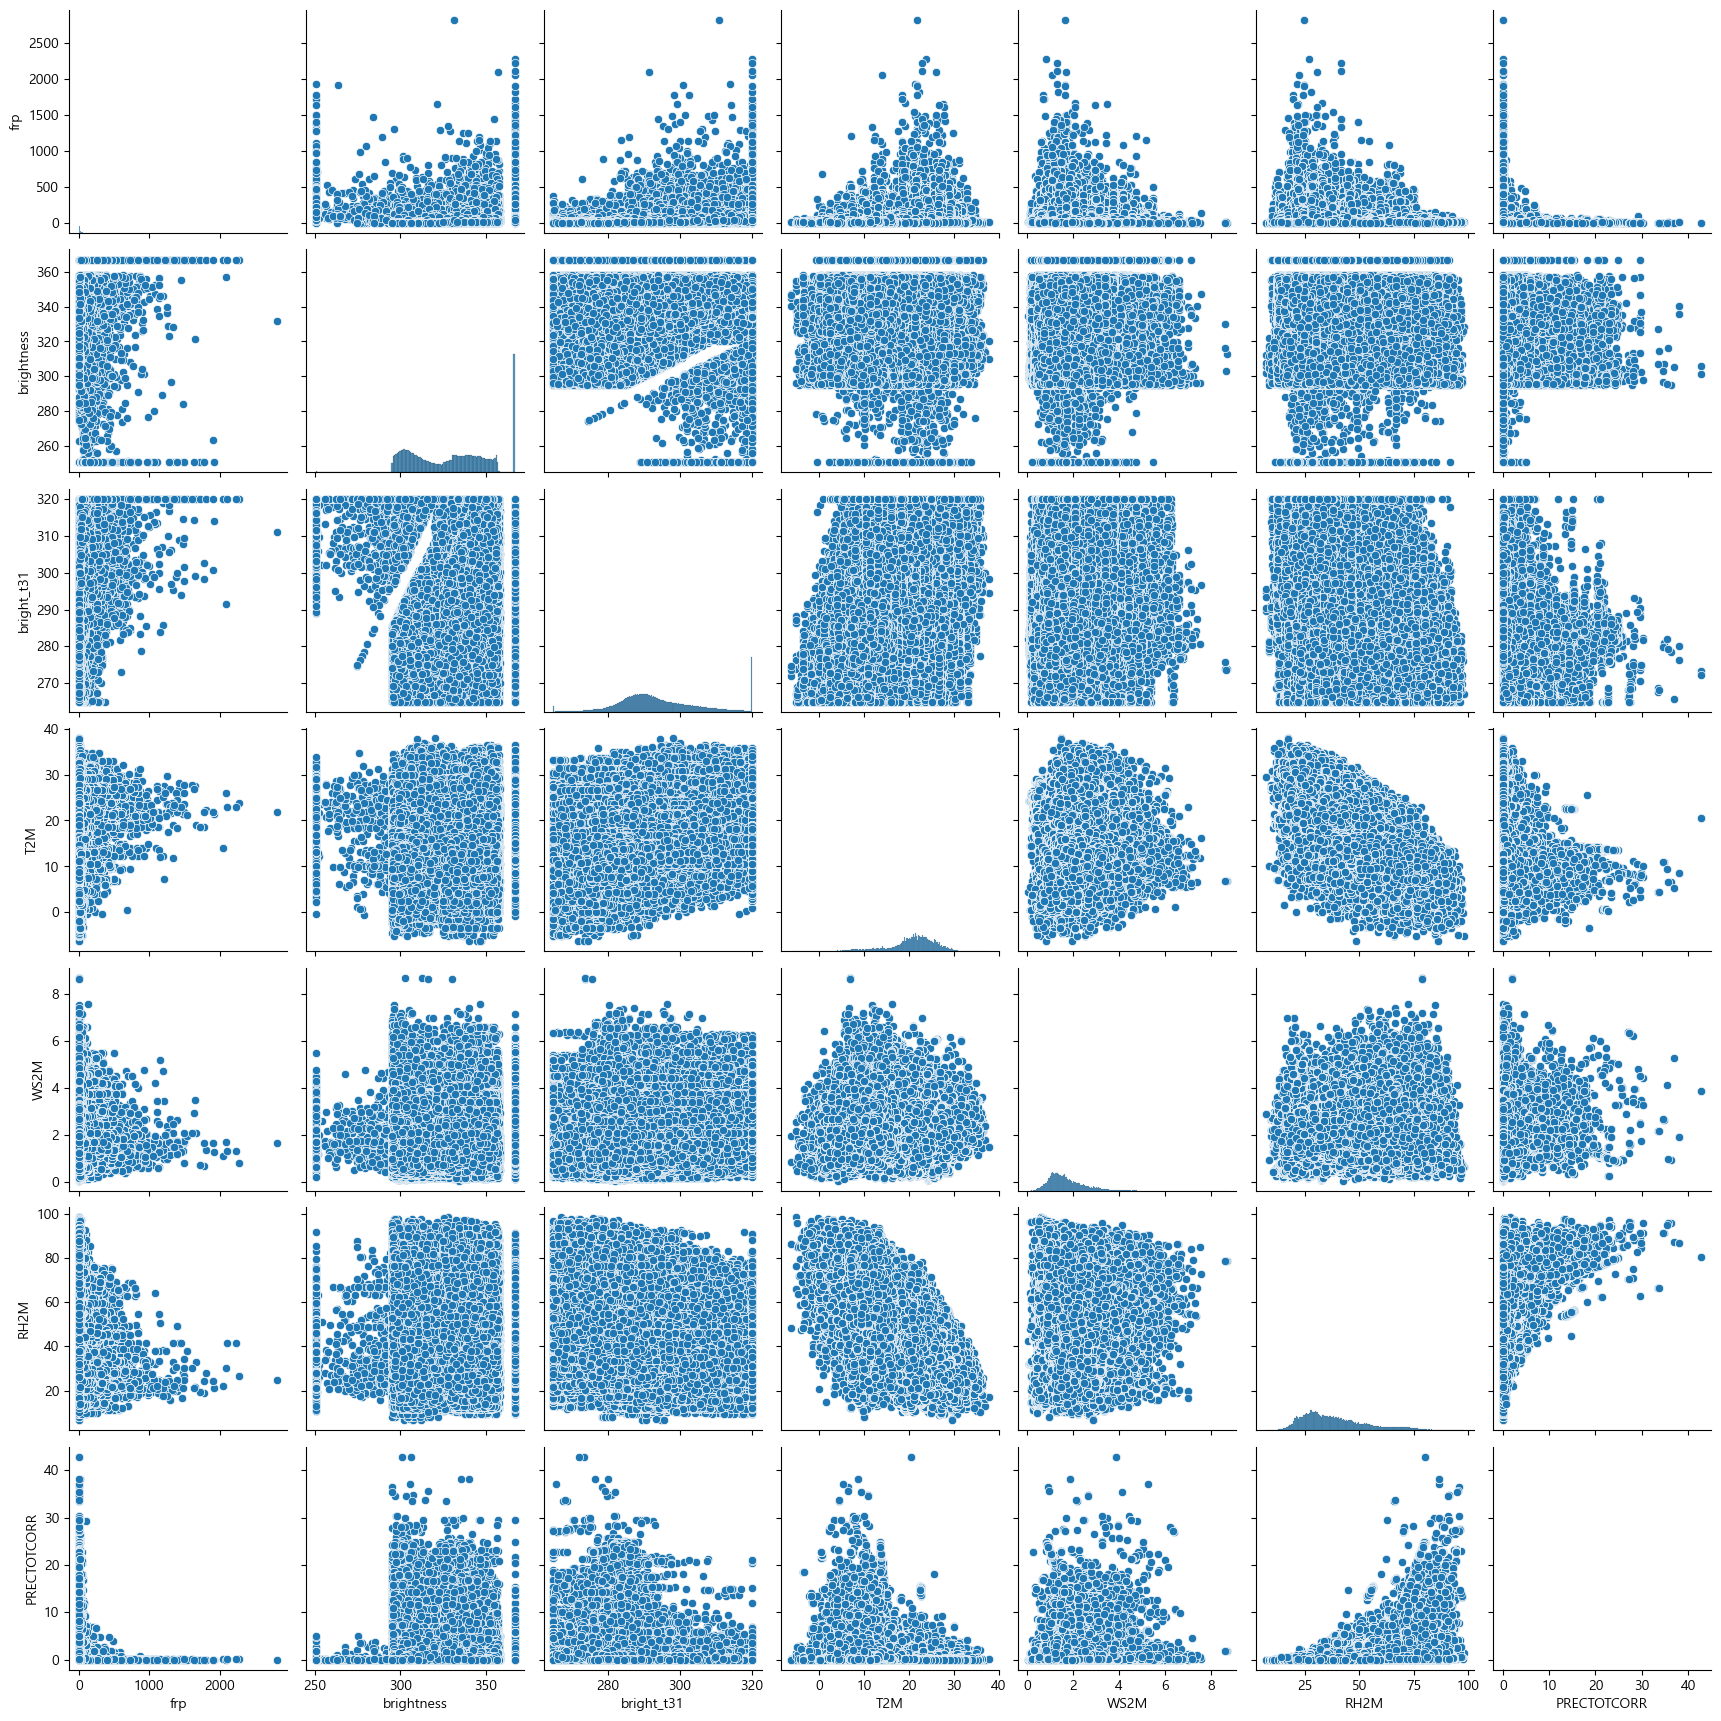

In [ ]:
# 선택한 컬럼들로 Pairplot 시각화
selected_columns = ["frp", "brightness", "bright_t31", "T2M", "WS2M", "RH2M", "PRECTOTCORR"]
sns.pairplot(cleaned_wildfire_df[selected_columns])
plt.show()

###  Pairplot 해석 (변수 간 관계 분석)
# frp vs brightness, frp vs bright_t31에서 약한 양의 선형 관계 보임.
# RH2M(습도)와 T2M(기온)에서 음의 상관관계가 시각적으로 드러남.
# PRECTOTCORR(강수량)는 대부분의 변수와 선형적인 관계가 거의 없음 → 회귀 분석 시 비선형 변환을 고려할 필요가 있음.

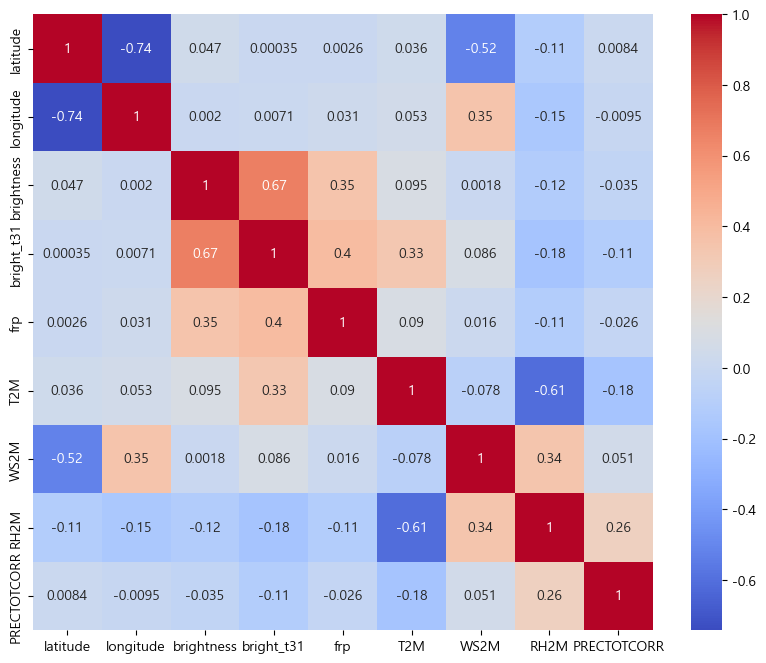

In [ ]:
# 상관 관계 시각화
corr = cleaned_wildfire_df.drop(columns=["confidence", "daynight", "datetime"]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

# 해설
# brightness와 bright_t31은 0.67로 강한 양의 상관관계를 보임 → 밝은 불꽃일수록 높은 온도를 가짐.
# frp와 brightness(0.35), bright_t31(0.4)도 양의 상관관계를 가짐 → 더 밝고 뜨거운 불꽃일수록 에너지가 큼.
# RH2M(습도)와 T2M(기온)은 -0.61의 음의 상관관계 → 일반적으로 기온이 높을수록 습도는 낮아짐.
# PRECTOTCORR(강수량)과 대부분의 변수 간 상관관계는 낮음 → 강수량이 FRP에 미치는 영향이 약하거나, 직접적인 관계보다는 시차 효과가 있을 가능성.


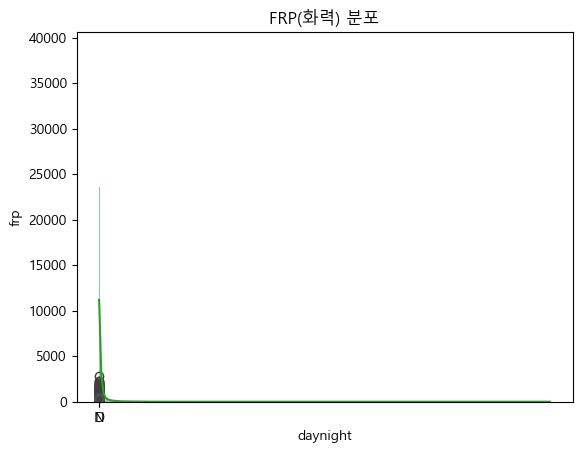

In [ ]:
# 산불 데이터의 분포 확인
sns.boxplot(x="daynight", y="frp", data=cleaned_wildfire_df)
sns.boxplot(x="daynight", y="brightness", data=cleaned_wildfire_df)

# 산불 강도(frp)의 분포 확인
sns.histplot(cleaned_wildfire_df['frp'], kde=True)
plt.title("FRP(화력) 분포")
plt.show()

# 해석
# 3. FRP(화력) vs 주야간(daynight)
# 그래프에서 N(Night)에 데이터가 몰려 있으며, 야간의 FRP 값이 낮은 경우가 많음.
# 낮(Day)의 데이터가 상대적으로 적거나 시각적으로 표현되지 않은 것으로 보임.
# 야간에는 화재 감지 빈도가 낮거나, 산불이 더 적게 발생하는 경향이 있을 수 있음.

# 야간 vs 주간 FRP:
# 야간에는 화재 감지가 어려울 가능성이 있고, 실제로도 낮보다 낮은 FRP 값을 보임.


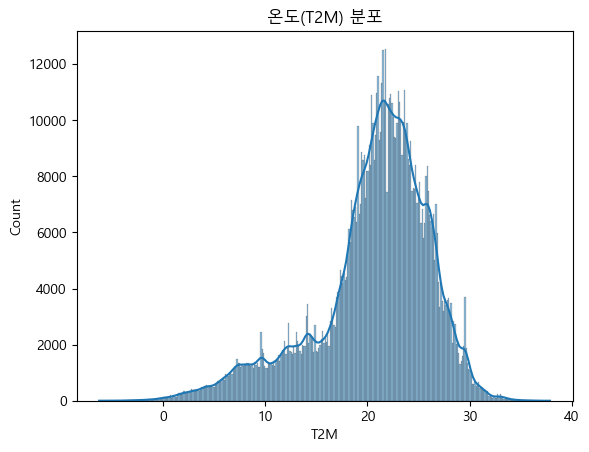

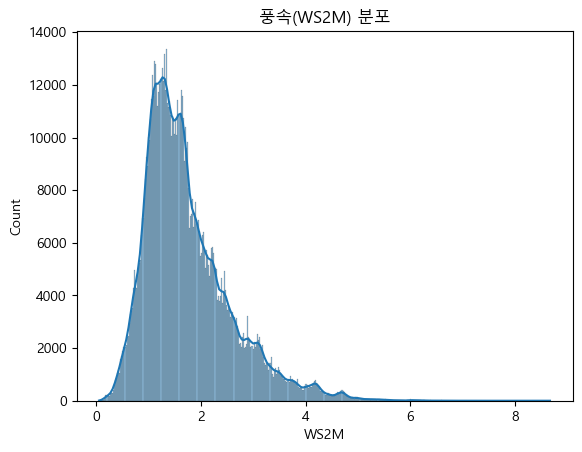

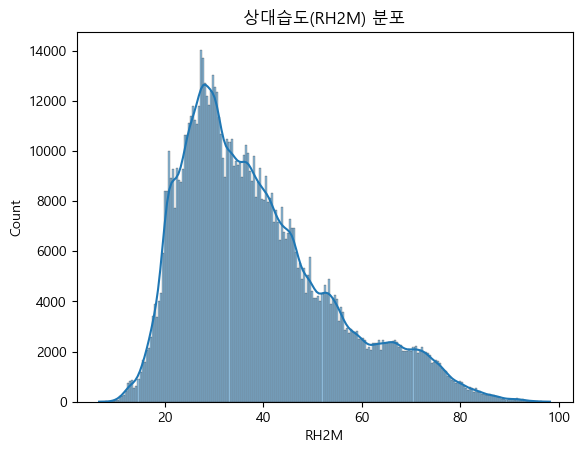

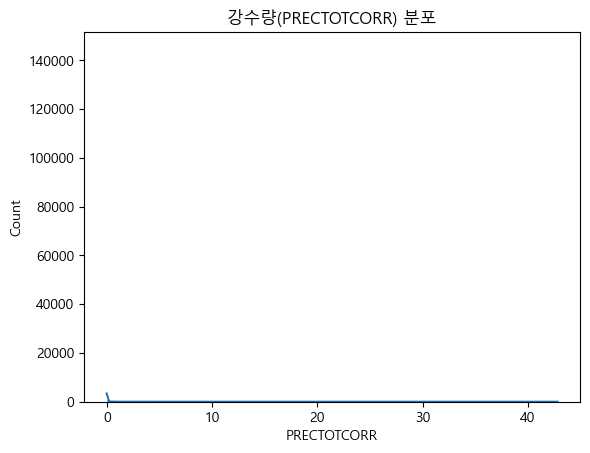

In [ ]:
# 기상 변수의 분포 확인
sns.histplot(cleaned_wildfire_df["T2M"], kde=True)
plt.title('온도(T2M) 분포')
plt.show()

sns.histplot(cleaned_wildfire_df['WS2M'], kde=True)
plt.title('풍속(WS2M) 분포')
plt.show()

sns.histplot(cleaned_wildfire_df['RH2M'], kde=True)
plt.title('상대습도(RH2M) 분포')
plt.show()

sns.histplot(cleaned_wildfire_df['PRECTOTCORR'], kde=True)
plt.title('강수량(PRECTOTCORR) 분포')
plt.show()

# 데이터 분포 해석
# 1. 온도 (T2M) 분포
# 전반적으로 정규 분포 형태를 보이며, 20°C 부근에서 가장 빈도가 높음.
# 오른쪽 꼬리가 길어 고온 구간의 데이터가 일부 포함됨.
# 시각적으로 이상치는 많지 않아 보임.

# 2. 풍속 (WS2M) 분포
# 0~2m/s 구간에서 가장 빈도가 높으며, 비대칭적인 오른쪽 꼬리 분포(right-skewed).
# 풍속이 낮은 경우가 압도적으로 많음.
# 2.5m/s 이상은 상대적으로 드물어 보임. 기상은 매번 다르니 이상치라 판단하기  어려움

# 3. 상대습도 (RH2M) 분포
# 20~40%에서 가장 많은 데이터가 분포하며, 전체적으로 왼쪽으로 치우친 분포(left-skewed).
# 100%에 가까운 값도 일부 존재함.
# 습도가 낮은 지역에서의 데이터가 많은 것으로 추정됨.

# 4. 강수량 (PRECTOTCORR) 분포
# 대부분의 데이터가 0에 몰려 있고, 일부 극단적으로 높은 값이 있음.
# 강수량 데이터가 편향되어 있으며, 0이 많은 희소 데이터(sparse data)로 보임.
# 로그 변환(log1p)을 적용하면 정규성 개선 가능.


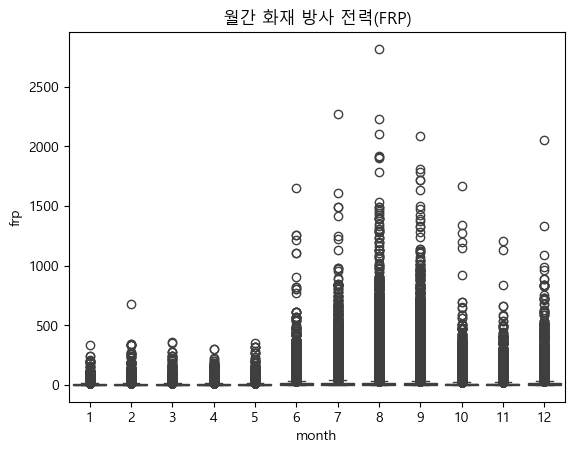

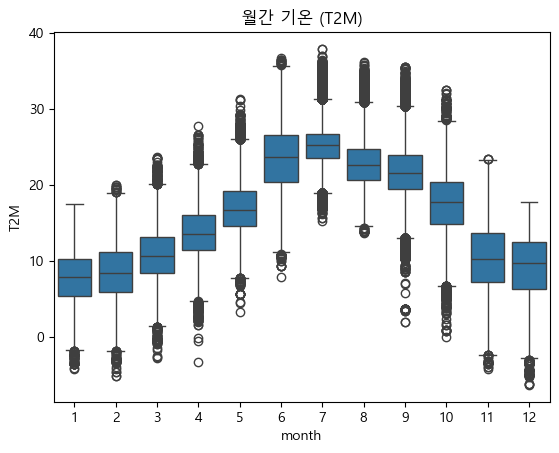

In [ ]:
# 날짜와 시간대별 분포 분석
cleaned_wildfire_df["datetime"] = pd.to_datetime(cleaned_wildfire_df["datetime"])
cleaned_wildfire_df["year"] = cleaned_wildfire_df["datetime"].dt.year
cleaned_wildfire_df["month"] = cleaned_wildfire_df["datetime"].dt.month
cleaned_wildfire_df["day"] = cleaned_wildfire_df["datetime"].dt.day

# 월별 화재 방사 전력(FRP) 분석
sns.boxplot(x="month", y="frp", data=cleaned_wildfire_df)
plt.title("월간 화재 방사 전력(FRP)")
plt.show()

# 월별 기온(T2M) 분석
sns.boxplot(x="month", y="T2M", data=cleaned_wildfire_df)
plt.title("월간 기온 (T2M)")
plt.show()


### 월간 화재 방사 전력(FRP) 박스플롯 해석
# 1. 월간 기온(T2M) 박스플롯
# 여름(6~8월) 동안 기온이 가장 높으며, 중앙값이 20~30도 사이에 위치.
# 겨울(12~2월) 동안 기온이 가장 낮으며, 중앙값이 0~10도 사이.
# 월별로 기온 변동 폭이 다름. 특히 여름에는 이상치(Outliers)가 많아 기온 변화가 상대적으로 큼.

# 2. 월간 화재 방사 전력(FRP) 분포
# 여름(6~9월)에 FRP(화재 강도)가 증가하는 경향을 보임.
# 8월에 가장 많은 화재가 발생하며, 극단적인 FRP 값(1000 이상)도 다수 존재.
# 겨울철(1~5월, 10~12월)에는 상대적으로 낮은 FRP 값을 보이며, 강한 산불이 적은 것으로 보임.

# 기온과 산불 강도(FRP)의 관계:
# 여름철(6~9월)에 기온이 상승함에 따라 화재 발생과 강도가 증가하는 경향이 뚜렷함.


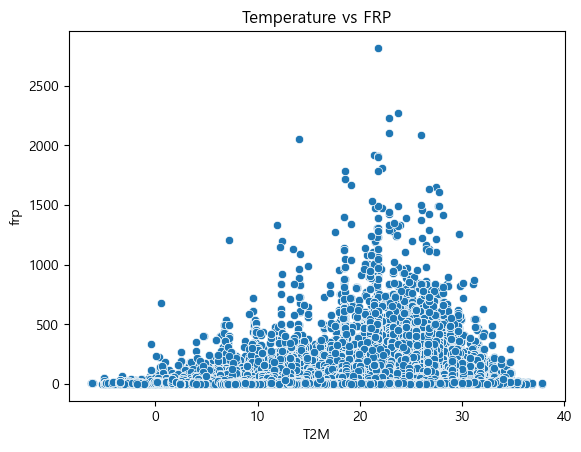

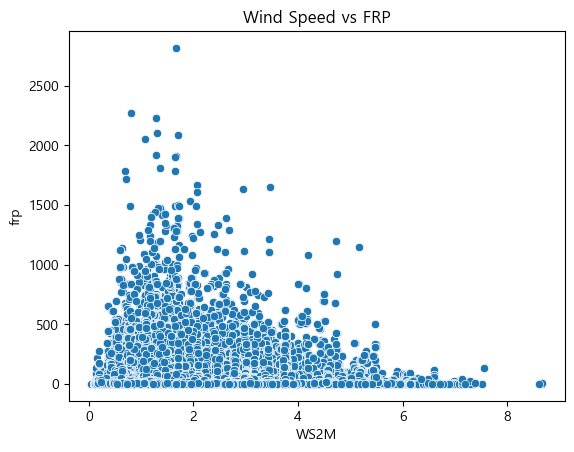

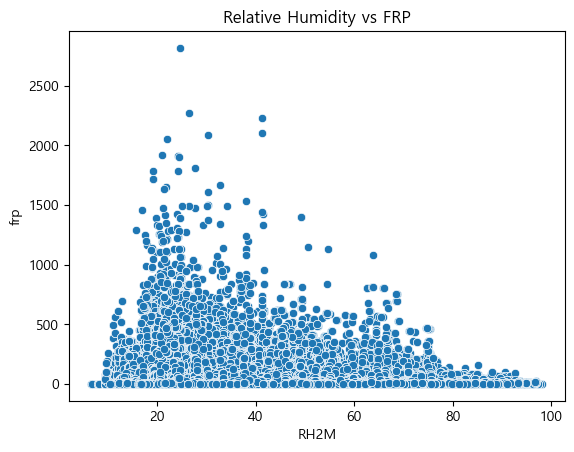

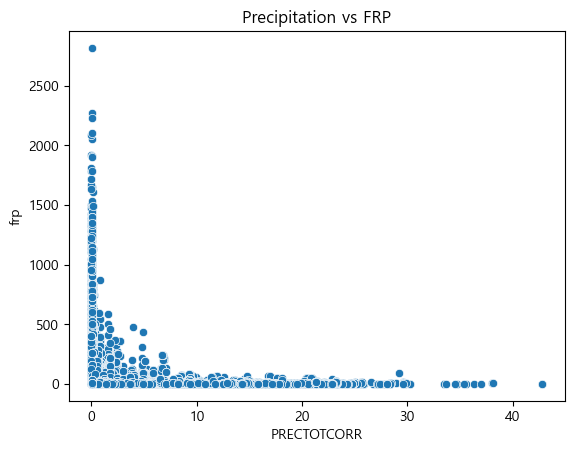

In [ ]:
# 기온(T2M)과 화재 방사 전력(FRP) 간의 관계
sns.scatterplot(x="T2M", y="frp", data=cleaned_wildfire_df)
plt.title("Temperature vs FRP")
plt.show()

# 풍속(WS2M)과 화재 방사 전력(FRP) 간의 관계
sns.scatterplot(x="WS2M", y="frp", data=cleaned_wildfire_df)
plt.title("Wind Speed vs FRP")
plt.show()

# 상대 습도(RH2M)와 화재 방사 전력(FRP) 간의 관계
sns.scatterplot(x="RH2M", y="frp", data=cleaned_wildfire_df)
plt.title("Relative Humidity vs FRP")
plt.show()

# 강수량(PRECTOTCORR)과 화재 방사 전력(FRP) 간의 관계
sns.scatterplot(x="PRECTOTCORR", y="frp", data=cleaned_wildfire_df)
plt.title("Precipitation vs FRP")
plt.show()

# 산불 데이터 시각화 해석
# 1. Temperature vs FRP (기온 vs 화재 방사 전력)
# T2M(기온)과 FRP(화재 방사 전력) 사이의 관계를 나타냄.
# 기온이 15~30도 사이에서 FRP 값이 높은 분포를 보임.
# 0도 이하에서는 화재 발생이 거의 없는 것으로 보임.
# 해석: 기온이 높을수록 화재가 더 강하게 발생할 가능성이 높아짐. 
#       특히 15~30도 사이에서 화재 강도가 두드러지는 것은 실제 산불 발생과 관련이 있을 수 있음.

# 2. Wind Speed vs FRP (풍속 vs 화재 방사 전력)
# WS2M(2m 높이의 풍속)과 FRP 사이의 관계를 나타냄.
# 풍속이 0~3m/s 구간에서 FRP가 높은 분포를 보임.
# 풍속이 5m/s 이상일 때는 FRP 값이 상대적으로 낮아지는 경향을 보임.
# 해석: 풍속이 0~3m/s일 때 산불 강도가 높아지는 것으로 보이며, 이는 바람이 산불 확산에 영향을 미치기 때문일 가능성이 있음. 
#       하지만 풍속이 너무 강해지면 화재 확산이 어려워져 FRP가 낮아지는 것으로 추측됨.

# 3. Relative Humidity vs FRP (습도 vs 화재 방사 전력)
# RH2M(상대습도)과 FRP 사이의 관계를 보여줌.
# 습도가 낮을수록 FRP가 높은 경향을 보임.
# 습도가 20~40%일 때 FRP가 높은 값으로 분포하는 경향이 있음.
# 해석: 습도가 낮을수록 화재 강도가 강해지는 것을 의미함. 
#       건조한 환경에서는 화재가 더 쉽게 발생하고 강한 산불로 이어질 가능성이 큼.

# 4. Precipitation vs FRP (강수량 vs 화재 방사 전력)
# PRECTOTCORR(강수량)과 FRP(화재 방사 전력) 사이의 관계를 보여주는 산점도.
# 강수량이 많을수록 FRP 값이 낮아지는 경향을 보임.
# 특히 강수량이 0~5mm 수준일 때 FRP 값이 높게 나타남.
# 해석: 강수량이 증가할수록 화재 발생 강도가 낮아지는 경향이 있음. 이는 예상 가능한 결과로, 
#       비가 많이 올수록 화재가 발생하거나 강하게 타오를 가능성이 줄어든다고 볼 수 있음.

# 종합적인 해석
# 강수량이 적고, 기온이 높으며, 바람이 적당히 불고, 습도가 낮을수록 화재가 강하게 발생하는 경향을 보임.
# 특히, 기온 1530도, 습도 2040%, 강수량 05mm, 풍속 03m/s일 때 FRP 값이 높은 분포를 보임.
# 이 결과를 바탕으로 머신러닝 모델을 학습할 때, 주요 변수로 강수량, 기온, 풍속, 습도를 활용하면 유의미한 예측이 가능할 것으로 보임.

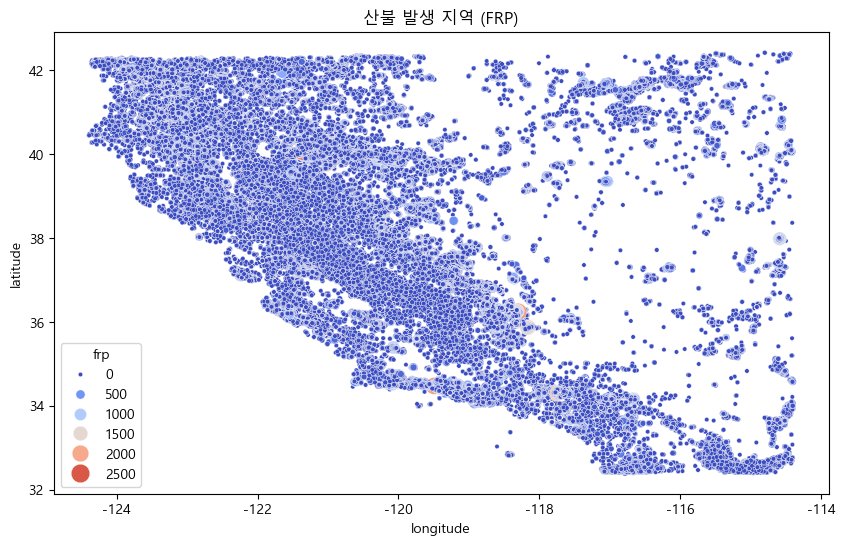

In [ ]:
# 산불 발생 지역 시각화 (위도, 경도)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', data=cleaned_wildfire_df, hue='frp', palette='coolwarm', size='frp', sizes=(10, 200))
plt.title('산불 발생 지역 (FRP)')
plt.show()

# 산불 발생 지역 (FRP의 지리적 분포) 해석
# 위도(latitude)와 경도(longitude)를 기준으로 산불 발생 지역을 표시했으며, FRP(Fire Radiative Power, 화재 복사 에너지)가 클수록 색이 붉고 크기가 큼.
# 대부분의 산불이 특정 지역(서부 해안 지역)에 집중되어 있음.
# FRP가 높은 곳(붉은 원)이 일부 지역에 군집되어 있음 → 강한 산불이 특정 지역에서 발생.
# 산불이 주로 서부에서 발생하는 패턴이 보이며, 이는 건조한 기후 때문일 가능성이 큼.

In [5]:
print(cleaned_wildfire_df.info())
print(cleaned_wildfire_df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 900596 entries, 0 to 900595
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   latitude     900596 non-null  float64       
 1   longitude    900596 non-null  float64       
 2   brightness   900596 non-null  float64       
 3   confidence   900596 non-null  object        
 4   bright_t31   900596 non-null  float64       
 5   frp          900596 non-null  float64       
 6   daynight     900596 non-null  object        
 7   T2M          900596 non-null  float64       
 8   WS2M         900596 non-null  float64       
 9   RH2M         900596 non-null  float64       
 10  PRECTOTCORR  900596 non-null  float64       
 11  datetime     900596 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(9), object(2)
memory usage: 89.3+ MB
None
            latitude      longitude     brightness     bright_t31  \
count  900596.000000  900596.000000  900596.0000

In [6]:
# 원핫 인코딩 적용
cleaned_wildfire_df = pd.get_dummies(cleaned_wildfire_df, columns=['confidence', 'daynight'], dtype=int)

# 결과 확인
cleaned_wildfire_df.head()

,latitude,longitude,brightness,bright_t31,frp,T2M,WS2M,RH2M,PRECTOTCORR,datetime,confidence_h,confidence_l,confidence_n,daynight_D,daynight_N
0,41.18757,-121.76961,303.88,266.14,1.17,-3.275956,0.659219,68.094241,0.000161,2015-01-01 09:56:00,0,0,1,0,1
1,41.18763,-121.76556,297.14,265.25,1.74,-3.262186,0.663444,68.034685,0.000164,2015-01-01 09:56:00,0,0,1,0,1
2,35.51954,-119.72784,302.88,270.62,1.20,4.008612,1.561859,50.105659,0.008027,2015-01-01 09:57:00,0,0,1,0,1
3,37.82349,-120.96186,299.62,271.62,0.82,2.606993,1.395697,56.702233,0.001027,2015-01-01 09:57:00,0,0,1,0,1
4,38.91062,-121.17077,303.10,272.36,1.11,1.478034,1.415668,57.134669,0.000682,2015-01-01 09:57:00,0,0,1,0,1


In [7]:
# 로그 변환을 적용할 변수 목록
cols_to_log_transform = ['brightness', 'bright_t31', 'WS2M', 'PRECTOTCORR', 'frp']

# 각 변수에 대해 로그 변환 적용
for col in cols_to_log_transform:
    # np.log1p()는 log(1 + x)를 계산하여 0인 값도 안전하게 처리할 수 있음
    cleaned_wildfire_df[col] = np.log1p(cleaned_wildfire_df[col])

# 결과 확인 (변환된 값들)
cleaned_wildfire_df[cols_to_log_transform].head()

# 주석 해석:
# brightness, bright_t31, WS2M, PRECTOTCORR, frp: 이 변수들은 분포가 비대칭적이거나 극단적인 값들이 존재하여 모델이 잘 학습하지 못할 수 있습니다. 
# 로그 변환을 통해 이러한 분포를 정규 분포에 가깝게 만들 수 있으며, 모델이 더 잘 학습할 수 있도록 돕습니다.
# np.log1p(): log(1 + x)로 0인 값도 변환할 수 있도록 해주는 함수입니다. 
# 이는 0인 값이 있을 수 있는 변수들에 대해서도 안전하게 로그 변환을 수행할 수 있게 도와줍니다.

,brightness,bright_t31,WS2M,PRECTOTCORR,frp
0,5.719918,5.587773,0.506347,0.000161,0.774727
1,5.697563,5.584436,0.508890,0.000164,1.007958
2,5.716633,5.604404,0.940733,0.007995,0.788457
3,5.705847,5.608079,0.873674,0.001026,0.598837
4,5.717357,5.610790,0.881976,0.000682,0.746688


In [8]:
# 날짜 정보 Feature Engineering

cleaned_wildfire_df['year'] = cleaned_wildfire_df['datetime'].dt.year  
cleaned_wildfire_df['month'] = cleaned_wildfire_df['datetime'].dt.month  
cleaned_wildfire_df['day'] = cleaned_wildfire_df['datetime'].dt.day  
cleaned_wildfire_df['season'] = cleaned_wildfire_df['month'] % 12 // 3 + 1  # 1: 겨울, 2: 봄, 3: 여름, 4: 가을  
cleaned_wildfire_df['weekday'] = cleaned_wildfire_df['datetime'].dt.weekday  # 0(월) ~ 6(일)

# datetime 컬럼을 그대로 두는 것보다 연, 월, 일, 계절, 요일 정보를 추출해서 쓰는 게 모델 성능에 도움 된다고 판단

# Feature Engineering이 완료된 데이터프레임 확인
cleaned_wildfire_df[['year', 'month', 'day', 'season', 'weekday']].head()

,year,month,day,season,weekday
0,2015,1,1,1,3
1,2015,1,1,1,3
2,2015,1,1,1,3
3,2015,1,1,1,3
4,2015,1,1,1,3


In [9]:
cleaned_wildfire_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 900596 entries, 0 to 900595
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   latitude      900596 non-null  float64       
 1   longitude     900596 non-null  float64       
 2   brightness    900596 non-null  float64       
 3   bright_t31    900596 non-null  float64       
 4   frp           900596 non-null  float64       
 5   T2M           900596 non-null  float64       
 6   WS2M          900596 non-null  float64       
 7   RH2M          900596 non-null  float64       
 8   PRECTOTCORR   900596 non-null  float64       
 9   datetime      900596 non-null  datetime64[ns]
 10  confidence_h  900596 non-null  int32         
 11  confidence_l  900596 non-null  int32         
 12  confidence_n  900596 non-null  int32         
 13  daynight_D    900596 non-null  int32         
 14  daynight_N    900596 non-null  int32         
 15  year          900596 n

In [10]:
### 풍속과 습도의 상호작용 특성 (Wind Speed * Humidity Interaction)
# 산불 발생에 있어 풍속과 습도는 중요한 변수입니다. 특히, 풍속이 빠를수록 산불이 확산되며, 습도가 낮을수록 산불의 확산 속도는 증가할 수 있습니다. 이를 반영한 상호작용 특성을 추가합니다.

cleaned_wildfire_df['WS2M_RH2M_interaction'] = cleaned_wildfire_df['WS2M'] * cleaned_wildfire_df['RH2M']

# 설명: 풍속(WS2M)과 습도(RH2M)는 산불의 확산에 중요한 영향을 미칩니다. 
#       풍속이 빠를수록 불이 빠르게 퍼지고, 습도가 낮을수록 불이 강하게 확산
# 효과: 풍속과 습도가 산불 강도에 미치는 영향을 독립적으로 고려하는 것보다 상호작용 특성을 반영함으로써 더 나은 모델링이 가능할 것으로 예상


In [11]:
### 고온 여부 (High Temperature Flag)
# 기온(T2M)이 특정 임계값을 초과하는지 여부를 확인하여, 고온 여부를 나타내는 이진 특성을 생성합니다. 예를 들어, 30°C 이상의 기온을 고온으로 설정할 수 있습니다.

cleaned_wildfire_df['high_temperature'] = (cleaned_wildfire_df['T2M'] > 30).astype(int)
# 이 특성은 산불 발생과 고온 간의 관계를 모델링하는 데 도움이 될 수 있습니다.

# 설명: 30°C 이상의 기온을 고온 여부로 변환하는 특성을 추가하는 것은 산불 발생의 중요한 특징을 반영한 것입니다. 
#       높은 기온은 산불 발생 가능성을 크게 높입니다.
# 효과: 고온을 이진 변수로 처리하여 기온이 일정 수준 이상일 때 산불 확산 가능성에 미치는 영향을 명확히 반영할 수 있습니다.

In [12]:
### 습도 범주화 (Humidity Binning)
# 습도(RH2M)가 산불에 미치는 영향을 더 잘 모델링하려면, 습도를 몇 가지 구간으로 나누어 범주화할 수 있습니다. 예를 들어, 저습도, 중간습도, 고습도로 나눌 수 있습니다.

# 습도 범주화 (Humidity Binning)
humidity_bins = [0, 30, 60, 100]
humidity_labels = ['low', 'medium', 'high']
cleaned_wildfire_df['RH2M_binned'] = pd.cut(cleaned_wildfire_df['RH2M'], 
                                            bins=humidity_bins, 
                                            labels=humidity_labels, 
                                            include_lowest=True)

In [13]:
### 기온 범주화 (Temperature Binning)
# 기온(T2M)을 몇 가지 범주로 나누어, 고온과 저온을 구분하는 변수를 추가할 수 있습니다. 

# 기온 범주화 (Temperature Binning)
temperature_bins = [-5, 15, 30, 45]  # 최소값 -5°C 반영
temperature_labels = ['low', 'medium', 'high']
cleaned_wildfire_df['T2M_binned'] = pd.cut(cleaned_wildfire_df['T2M'], 
                                           bins=temperature_bins, 
                                           labels=temperature_labels, 
                                           include_lowest=True)

# 설명: **기온(T2M)**을 세 개의 범주로 나누어 고온, 중온, 저온을 구분하는 변수를 추가하는 것도 좋은 접근입니다. 
#       기온이 높을수록 산불 발생의 가능성이 높아지기 때문에 이 범주화를 통해 모델이 기온의 범위에 따라 어떻게 반응하는지 파악할 수 있습니다.
# 효과: 기온을 이진 변수로 처리하는 것보다 더 구체적인 범주로 나누어 기온이 산불에 미치는 영향을 더 세밀하게 분석할 수 있게 됩니다.

In [14]:
### 강수량 여부 (Precipitation Flag)
# 강수량 (PRECTOTCORR)이 0인 경우에는 강수량 없음으로, 그렇지 않으면 강수량 있음으로 구분하는 이진 특성을 추가합니다.
# 강수량이 많으면 산불 발생이 줄어들 수 있으므로 이 특성은 예측 모델에 중요한 영향을 미칠 수 있습니다.

cleaned_wildfire_df['precipitation_flag'] = (cleaned_wildfire_df['PRECTOTCORR'] > 0).astype(int)


In [25]:
"""
피처 엔지니어링 요약
피처 엔지니어링을 통해 추가할 수 있는 특성들:

풍속과 습도의 상호작용 특성 (WS2M_RH2M_interaction): 풍속과 습도의 상호작용을 나타내는 특성.
고온 여부 (high_temperature): 기온이 30도 이상인 경우를 고온으로 표시하는 특성.
습도 범주화 (RH2M_binned): 습도를 저, 중, 고로 구분하여 범주형 특성으로 추가.
기온 범주화 (T2M_binned): 기온을 저, 중, 고온으로 범주화하여 모델링에 활용.
강수량 여부 (precipitation_flag): 강수량이 0인지 아닌지에 따라 산불 발생과의 관계를 반영할 수 있는 이진 특성.
"""

'\n피처 엔지니어링 요약\n피처 엔지니어링을 통해 추가할 수 있는 특성들:\n\n풍속과 습도의 상호작용 특성 (WS2M_RH2M_interaction): 풍속과 습도의 상호작용을 나타내는 특성.\n고온 여부 (high_temperature): 기온이 30도 이상인 경우를 고온으로 표시하는 특성.\n습도 범주화 (RH2M_binned): 습도를 저, 중, 고로 구분하여 범주형 특성으로 추가.\n기온 범주화 (T2M_binned): 기온을 저, 중, 고온으로 범주화하여 모델링에 활용.\n강수량 여부 (precipitation_flag): 강수량이 0인지 아닌지에 따라 산불 발생과의 관계를 반영할 수 있는 이진 특성.\n'

In [15]:
cleaned_wildfire_df.head()

,latitude,longitude,brightness,bright_t31,frp,T2M,WS2M,RH2M,PRECTOTCORR,datetime,...,year,month,day,season,weekday,WS2M_RH2M_interaction,high_temperature,RH2M_binned,T2M_binned,precipitation_flag
0,41.18757,-121.76961,5.719918,5.587773,0.774727,-3.275956,0.506347,68.094241,0.000161,2015-01-01 09:56:00,...,2015,1,1,1,3,34.479330,0,high,low,1
1,41.18763,-121.76556,5.697563,5.584436,1.007958,-3.262186,0.508890,68.034685,0.000164,2015-01-01 09:56:00,...,2015,1,1,1,3,34.622201,0,high,low,1
2,35.51954,-119.72784,5.716633,5.604404,0.788457,4.008612,0.940733,50.105659,0.007995,2015-01-01 09:57:00,...,2015,1,1,1,3,47.136062,0,medium,low,1
3,37.82349,-120.96186,5.705847,5.608079,0.598837,2.606993,0.873674,56.702233,0.001026,2015-01-01 09:57:00,...,2015,1,1,1,3,49.539279,0,medium,low,1
4,38.91062,-121.17077,5.717357,5.610790,0.746688,1.478034,0.881976,57.134669,0.000682,2015-01-01 09:57:00,...,2015,1,1,1,3,50.391387,0,medium,low,1


In [16]:
# 불필요한 컬럼 삭제
# 'datetime' 컬럼은 이미 연도, 월, 일, 요일, 계절 등의 정보를 나누었으므로 삭제
cleaned_wildfire_df.drop(columns=['datetime'], inplace=True)

# 결과 확인
cleaned_wildfire_df.head()


,latitude,longitude,brightness,bright_t31,frp,T2M,WS2M,RH2M,PRECTOTCORR,confidence_h,...,year,month,day,season,weekday,WS2M_RH2M_interaction,high_temperature,RH2M_binned,T2M_binned,precipitation_flag
0,41.18757,-121.76961,5.719918,5.587773,0.774727,-3.275956,0.506347,68.094241,0.000161,0,...,2015,1,1,1,3,34.479330,0,high,low,1
1,41.18763,-121.76556,5.697563,5.584436,1.007958,-3.262186,0.508890,68.034685,0.000164,0,...,2015,1,1,1,3,34.622201,0,high,low,1
2,35.51954,-119.72784,5.716633,5.604404,0.788457,4.008612,0.940733,50.105659,0.007995,0,...,2015,1,1,1,3,47.136062,0,medium,low,1
3,37.82349,-120.96186,5.705847,5.608079,0.598837,2.606993,0.873674,56.702233,0.001026,0,...,2015,1,1,1,3,49.539279,0,medium,low,1
4,38.91062,-121.17077,5.717357,5.610790,0.746688,1.478034,0.881976,57.134669,0.000682,0,...,2015,1,1,1,3,50.391387,0,medium,low,1


In [17]:
# 결과 확인
cleaned_wildfire_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 900596 entries, 0 to 900595
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   latitude               900596 non-null  float64 
 1   longitude              900596 non-null  float64 
 2   brightness             900596 non-null  float64 
 3   bright_t31             900596 non-null  float64 
 4   frp                    900596 non-null  float64 
 5   T2M                    900596 non-null  float64 
 6   WS2M                   900596 non-null  float64 
 7   RH2M                   900596 non-null  float64 
 8   PRECTOTCORR            900596 non-null  float64 
 9   confidence_h           900596 non-null  int32   
 10  confidence_l           900596 non-null  int32   
 11  confidence_n           900596 non-null  int32   
 12  daynight_D             900596 non-null  int32   
 13  daynight_N             900596 non-null  int32   
 14  year                   90

In [19]:
# 범주형 변수에 대해 원-핫 인코딩 처리 (T2M_binned, RH2M_binned)
cleaned_wildfire_df = pd.get_dummies(cleaned_wildfire_df, columns=['T2M_binned', 'RH2M_binned'], drop_first=True)

# 상관관계 계산
correlation_matrix = cleaned_wildfire_df.corr()

# 상관관계 행렬 출력 (상위 몇 개를 확인할 수 있습니다)
print(correlation_matrix.head())


            latitude  longitude  brightness  bright_t31       frp       T2M  \
latitude    1.000000  -0.741772    0.049995    0.002423  0.056009  0.035917   
longitude  -0.741772   1.000000   -0.001254    0.002780  0.006716  0.053377   
brightness  0.049995  -0.001254    1.000000    0.662564  0.736187  0.094171   
bright_t31  0.002423   0.002780    0.662564    1.000000  0.630510  0.331517   
frp         0.056009   0.006716    0.736187    0.630510  1.000000  0.141326   

                WS2M      RH2M  PRECTOTCORR  confidence_h  ...       day  \
latitude   -0.544378 -0.109223    -0.007798     -0.007510  ... -0.018011   
longitude   0.386725 -0.152697     0.011962      0.042670  ...  0.030875   
brightness  0.006655 -0.117748    -0.045385      0.487190  ... -0.021526   
bright_t31  0.089232 -0.180488    -0.147133      0.322049  ...  0.000950   
frp        -0.007449 -0.189150    -0.062343      0.371953  ... -0.030391   

              season   weekday  WS2M_RH2M_interaction  high_temperat

In [20]:
cleaned_wildfire_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 900596 entries, 0 to 900595
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   latitude               900596 non-null  float64
 1   longitude              900596 non-null  float64
 2   brightness             900596 non-null  float64
 3   bright_t31             900596 non-null  float64
 4   frp                    900596 non-null  float64
 5   T2M                    900596 non-null  float64
 6   WS2M                   900596 non-null  float64
 7   RH2M                   900596 non-null  float64
 8   PRECTOTCORR            900596 non-null  float64
 9   confidence_h           900596 non-null  int32  
 10  confidence_l           900596 non-null  int32  
 11  confidence_n           900596 non-null  int32  
 12  daynight_D             900596 non-null  int32  
 13  daynight_N             900596 non-null  int32  
 14  year                   900596 non-null  i

In [23]:
# 독립변수 X와 종속변수 y 정의
X = cleaned_wildfire_df[["brightness", "bright_t31", "T2M", "WS2M", "RH2M", "PRECTOTCORR", "confidence_h",
                         "confidence_l", "confidence_n", "daynight_D", "daynight_N", "WS2M_RH2M_interaction",
                         "high_temperature", "precipitation_flag", "T2M_binned_medium", "T2M_binned_high", 
                         "RH2M_binned_medium", "RH2M_binned_high"]]
y = cleaned_wildfire_df["frp"]

# 스피어만 상관관계 검증
for value in X:
    # Spearman 상관계수 계산
    statistic, pvalue = spearmanr(X[value], y)
    
    # 유의미한 상관관계 판단
    if pvalue < 0.05:
        print(f"상관관계 계수 {statistic:.3f}, p-value {pvalue} => ({value}) 독립변수는 종속변수(FRP)와 유의미한 상관관계를 가진다.")
    else:
        print(f"상관관계 계수 {statistic:.3f}, p-value {pvalue} => ({value}) 독립변수는 종속변수(FRP)와 유의미한 상관관계를 가지지 않는다.")


상관관계 계수 0.813, p-value 0.0 => (brightness) 독립변수는 종속변수(FRP)와 유의미한 상관관계를 가진다.
상관관계 계수 0.640, p-value 0.0 => (bright_t31) 독립변수는 종속변수(FRP)와 유의미한 상관관계를 가진다.
상관관계 계수 0.154, p-value 0.0 => (T2M) 독립변수는 종속변수(FRP)와 유의미한 상관관계를 가진다.
상관관계 계수 -0.026, p-value 5.098006897419322e-134 => (WS2M) 독립변수는 종속변수(FRP)와 유의미한 상관관계를 가진다.
상관관계 계수 -0.198, p-value 0.0 => (RH2M) 독립변수는 종속변수(FRP)와 유의미한 상관관계를 가진다.
상관관계 계수 -0.073, p-value 0.0 => (PRECTOTCORR) 독립변수는 종속변수(FRP)와 유의미한 상관관계를 가진다.
상관관계 계수 0.339, p-value 0.0 => (confidence_h) 독립변수는 종속변수(FRP)와 유의미한 상관관계를 가진다.
상관관계 계수 0.202, p-value 0.0 => (confidence_l) 독립변수는 종속변수(FRP)와 유의미한 상관관계를 가진다.
상관관계 계수 -0.404, p-value 0.0 => (confidence_n) 독립변수는 종속변수(FRP)와 유의미한 상관관계를 가진다.
상관관계 계수 0.601, p-value 0.0 => (daynight_D) 독립변수는 종속변수(FRP)와 유의미한 상관관계를 가진다.
상관관계 계수 -0.601, p-value 0.0 => (daynight_N) 독립변수는 종속변수(FRP)와 유의미한 상관관계를 가진다.
상관관계 계수 -0.146, p-value 0.0 => (WS2M_RH2M_interaction) 독립변수는 종속변수(FRP)와 유의미한 상관관계를 가진다.
상관관계 계수 0.024, p-value 3.767171997886371e-112 => (high_temperatu

In [24]:
# 저장 (필요한 경우)
cleaned_wildfire_df.to_csv("./USA data/cleaned_wildfire.csv", index=False)